In [1]:
from keras.models import load_model
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


2023-08-20 10:22:11.064996: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-20 10:22:11.095344: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
Z_DIM = 100

vector_keygen = lambda: np.random.uniform(-1, 1, size=(Z_DIM,))
sign_swap = lambda x, k: x * np.sign(k)
modulo_add = lambda x, k: (x + k) % 2 - 1
modulo_sub = lambda x, k: (x - k) % 2 - 1
multiply = lambda x, k: x * k
divide = lambda x, k: x / k

scalar_keygen = lambda: np.random.uniform(-1, 1)
shift_forward = lambda x, k: np.roll(x, int(k * x.shape[1]), axis=1)
shift_backward = lambda x, k: np.roll(x, -int(k * x.shape[1]), axis=1)

keygen = vector_keygen
encrypt = sign_swap
decrypt = sign_swap

In [3]:
generator = load_model("generator.h5")
encoder = load_model("encoder.h5")

2023-08-20 10:22:12.766260: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2276 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
RESULTS = 10

key = keygen()
alt_key = keygen()
ds = tfds.load("quickdraw_bitmap", split="train", shuffle_files=True, data_dir="/mnt/external/tensorflow_datasets")
assert isinstance(ds, tf.data.Dataset)
batch = ds.batch(RESULTS).take(1)
batch = batch.map(lambda x: (tf.cast(x["image"], tf.float32) - 127.5) / 127.5)
pto_images = next(iter(batch))

pto = encoder(pto_images)
cto = encrypt(pto, key)
cto_images = generator(cto)
alt_cto = encrypt(pto, alt_key)
alt_cto_images = generator(alt_cto)
ctr = encoder(cto_images)
ptr = decrypt(ctr, key)
ptr_images = generator(ptr)
ptw = decrypt(ctr, alt_key)
ptw_images = generator(ptw)

2023-08-20 10:22:13.187962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [256]
	 [[{{node Placeholder/_4}}]]
2023-08-20 10:22:13.188260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [256]
	 [[{{node Placeholder/_2}}]]
2023-08-20 10:22:14.648723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-08-20 10:22:14.758649: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-20 10:22:15.016433: I tensorflow/compiler/xla/st

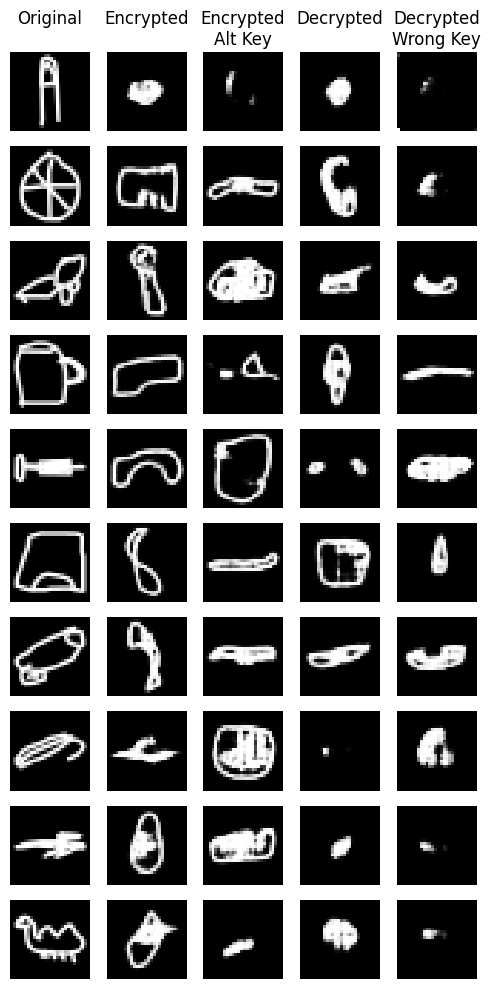

In [5]:
plt.figure(figsize=(5, RESULTS))
cols = ["Original\n", "Encrypted\n", "Encrypted\nAlt Key", "Decrypted\n", "Decrypted\nWrong Key"]
for i in range(RESULTS):
    plt.subplot(RESULTS, 5, 5 * i + 1)
    plt.imshow(pto_images[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[0])
    plt.subplot(RESULTS, 5, 5 * i + 2)
    plt.imshow(cto_images[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[1])
    plt.subplot(RESULTS, 5, 5 * i + 3)
    plt.imshow(alt_cto_images[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[2])
    plt.subplot(RESULTS, 5, 5 * i + 4)
    plt.imshow(ptr_images[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[3])
    plt.subplot(RESULTS, 5, 5 * i + 5)
    plt.imshow(ptw_images[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[4])
plt.tight_layout()
plt.savefig("results.png")
plt.show()
